# Pivot diffusion map

# 1. Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import linalg
%matplotlib inline
import mdtraj as md
import nglview as nv
import dmaps
import math
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D
from numpy import matlib as mb
import os
import pickle
import time

_ColormakerRegistry()

# 2. Import Trajectories

In [2]:
traj = md.load('trj_whole.xtc', top='traj_pbc.gro')[:5000]

# 3. Calculate Gyration Radius

In [3]:
def principal_ax(traj):
    traj.center_coordinates()
    X = np.array([X.T.dot(X)/X.shape[0] for X in traj.xyz])
    evecs = np.linalg.eigvalsh(X)[:,::-1]
    return np.sqrt(evecs)*10

In [4]:
gt = principal_ax(traj)

In [5]:
gt.shape

(5000, 3)

In [6]:
gt1 = gt[:,0]
gt2 = gt[:,1]
gt3 = gt[:,2]

# 4. Select Points as base for diffusion map

In [7]:
Xdata = traj.xyz

In [8]:
Xdata.shape

(5000, 24, 3)

In [9]:
distXdata = dmaps.DistanceMatrix(Xdata.reshape(-1,72))

In [10]:
print("Starting pivot...")
#f = open('pivot_matrix.npy', 'wb')
r_cut =0.093

N = Xdata.shape[0]
print(f"Finding the pivot for {N} data points")
P = np.zeros(N)
n=-1
start = time.time()
for i in range(N):
    if P[i]==0:
        P[i]=1
        n+=1
        temp = distXdata.compute_single(Xdata[n].reshape(-1),metric=dmaps.metrics.rmsd)
        P = np.where(np.logical_and(temp <= r_cut,P==0),2,P)
        #np.save(f,temp)
    if (i%100==0):
        print(100*i/N," % Done")
print("Pivot finished in {} seconds".format(time.time()-start))
#f.close()
print("Pivot Done!")
f = open('pivot_P_every20.npy', 'wb')
np.save(f,P)
f.close()

Starting pivot...
Finding the pivot for 5000 data points
0.0  % Done
2.0  % Done
4.0  % Done
6.0  % Done
8.0  % Done
10.0  % Done
12.0  % Done
14.0  % Done
16.0  % Done
18.0  % Done
20.0  % Done
22.0  % Done
24.0  % Done
26.0  % Done
28.0  % Done
30.0  % Done
32.0  % Done
34.0  % Done
36.0  % Done
38.0  % Done
40.0  % Done
42.0  % Done
44.0  % Done
46.0  % Done
48.0  % Done
50.0  % Done
52.0  % Done
54.0  % Done
56.0  % Done
58.0  % Done
60.0  % Done
62.0  % Done
64.0  % Done
66.0  % Done
68.0  % Done
70.0  % Done
72.0  % Done
74.0  % Done
76.0  % Done
78.0  % Done
80.0  % Done
82.0  % Done
84.0  % Done
86.0  % Done
88.0  % Done
90.0  % Done
92.0  % Done
94.0  % Done
96.0  % Done
98.0  % Done
Pivot finished in 67.72004985809326 seconds
Pivot Done!


In [11]:
n

4293

In [12]:
N

5000

In [13]:
P

array([1., 1., 1., ..., 1., 1., 1.])

In [14]:
P.shape

(5000,)

In [15]:
traj_n = np.zeros((N,24,3))
traj_N_n = np.zeros((N,24,3))
gt1final_n = np.zeros(N)
gt2final_n = np.zeros(N)
gt3final_n = np.zeros(N)
gt1final_N_n = np.zeros(N)
gt2final_N_n = np.zeros(N)
gt3final_N_n = np.zeros(N)

In [16]:
for i in range(P.shape[0]):
    if P[i] == 1:        
        traj_n[i,:] = traj[i].xyz
        gt1final_n[i] = gt1[i]
        gt2final_n[i] = gt2[i]
        gt3final_n[i] = gt3[i]
        
    elif P[i] == 2:
        traj_N_n[i,:] = traj[i].xyz
        gt1final_N_n[i] = gt1[i]
        gt2final_N_n[i] = gt2[i]
        gt3final_N_n[i] = gt3[i]

In [17]:
index = np.nonzero(gt1final_n)

In [18]:
index

(array([   0,    1,    2, ..., 4997, 4998, 4999]),)

In [19]:
traj_n = traj_n[np.nonzero(gt1final_n),:]

In [20]:
gt1final_n = gt1final_n[np.nonzero(gt1final_n)]
gt2final_n = gt2final_n[np.nonzero(gt2final_n)]
gt3final_n = gt3final_n[np.nonzero(gt3final_n)]

In [21]:
traj_N_n = traj_N_n[np.nonzero(gt1final_N_n),:]

In [22]:
gt1final_N_n = gt1final_N_n[np.nonzero(gt1final_N_n)]
gt2final_N_n = gt2final_N_n[np.nonzero(gt2final_N_n)]
gt3final_N_n = gt3final_N_n[np.nonzero(gt3final_N_n)]


In [23]:
gt1final_N_n.shape

(706,)

In [24]:
Xdata = traj_n

In [25]:
Xdata = Xdata.reshape(n+1,24,3)

In [26]:
Xdata.shape

(4294, 24, 3)

# 5. Symmetry Removal

In [27]:
xmirrorsymmetry = [-1, 1, 1]

In [28]:
traj_n = traj_n.reshape(n+1,24,3)

In [29]:
distX = dmaps.DistanceMatrix(traj_n.reshape(-1, 24*3))
distX.compute(metric=dmaps.metrics.rmsd)
x = distX.get_distances()

In [30]:
optimizeddataX = np.zeros((traj_n.shape[0],traj_n.shape[0]))
tempdata = np.copy(traj_n)

for snapshot in range(traj_n.shape[0]):    
    
    tempdata[snapshot,:] = np.multiply(traj_n[snapshot,:],mb.repmat(xmirrorsymmetry,24,1))
    d =distX.compute_single(tempdata[snapshot,:].reshape(-1),metric=dmaps.metrics.rmsd) 
    optimizeddataX[snapshot,:] = d

In [31]:
distflip = dmaps.DistanceMatrix(traj_n.reshape(-1, 24*3))
distflip.compute(metric=dmaps.metrics.rmsd)
flip = distflip.get_distances()

In [32]:
optimizeddataflip = np.zeros((traj_n.shape[0],traj_n.shape[0]))
tempdata = np.copy(traj_n)

for snapshot in range(traj_n.shape[0]):    
    
    tempdata[snapshot,:] = traj_n[snapshot,:][::-1]
    d =distflip.compute_single(tempdata[snapshot,:].reshape(-1),metric=dmaps.metrics.rmsd) 
    optimizeddataflip[snapshot,:] = d

In [33]:
optimizeddata = np.zeros((traj_n.shape[0],traj_n.shape[0]))
optimizeddata_flip = np.zeros((traj_n.shape[0],traj_n.shape[0]))
optimizeddata_x = np.zeros((traj_n.shape[0],traj_n.shape[0]))
for m in range(traj_n.shape[0]):
    for n in range(traj_n.shape[0]):
        optimizeddata[m,n] = min(x[m,n],optimizeddataflip[m,n],optimizeddataX[m,n])
        optimizeddata_flip[m,n] = min(x[m,n],optimizeddataflip[m,n])
        optimizeddata_x[m,n] = min(x[m,n],optimizeddataX[m,n])


In [34]:
dmap = dmaps.DiffusionMap(optimizeddata)
dmapflip = dmaps.DiffusionMap(optimizeddata_flip)
dmapx = dmaps.DiffusionMap(optimizeddata_x)


In [35]:
epss = 2.**np.arange(-16, 4, 1)


In [36]:
aij = [dmap.sum_similarity_matrix(eps) for eps in epss]
bij = [dmapflip.sum_similarity_matrix(eps) for eps in epss]
cij = [dmapx.sum_similarity_matrix(eps) for eps in epss]


(0, 0.05)

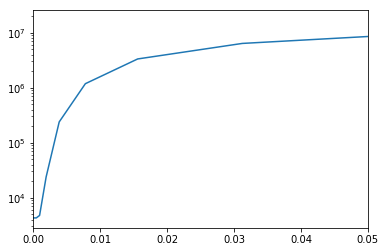

In [37]:
plt.semilogy(epss, aij)
plt.xlim([0, 0.05])


(0, 0.05)

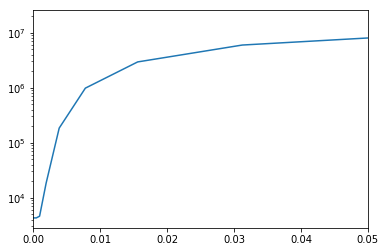

In [38]:
plt.semilogy(epss, bij)
plt.xlim([0, 0.05])


(0, 0.05)

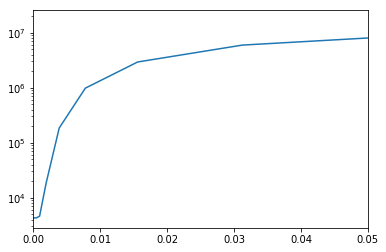

In [39]:
plt.semilogy(epss, cij)
plt.xlim([0, 0.05])


In [40]:
dmap.set_kernel_bandwidth(0.03)
dmap.compute(20)


In [41]:
dmapflip.set_kernel_bandwidth(0.03)
dmapflip.compute(20)


In [42]:
dmapx.set_kernel_bandwidth(0.03)
dmapx.compute(20)


In [43]:
vXdata = dmap.get_eigenvectors()
wXdata = dmap.get_eigenvalues()


In [44]:
vXdatax = dmapx.get_eigenvectors()
wXdatax = dmapx.get_eigenvalues()


In [45]:
vXdataflip = dmapflip.get_eigenvectors()
wXdataflip = dmapflip.get_eigenvalues()


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


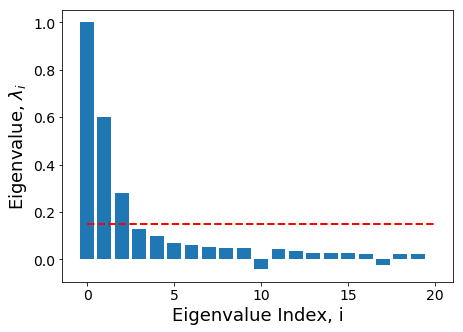

In [46]:
plt.figure(figsize=(7,5))
plt.bar(np.array(range(20)), wXdata)
ax = plt.subplot(1,1,1)
ax.set_xlabel('Eigenvalue Index, i',fontsize = 18)
ax.set_ylabel('Eigenvalue, $\lambda_i$',fontsize = 18)
ax.tick_params(labelsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.plot([-0,20], [0.15, 0.15], '--', lw=2,color = 'r')

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


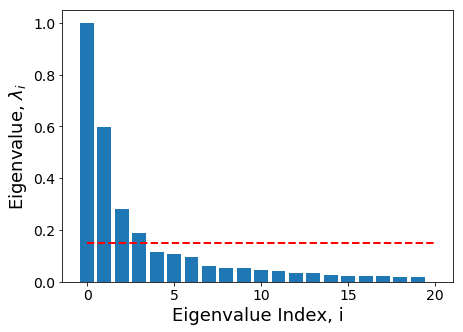

In [47]:
plt.figure(figsize=(7,5))
plt.bar(np.array(range(20)), wXdatax)
ax = plt.subplot(1,1,1)
ax.set_xlabel('Eigenvalue Index, i',fontsize = 18)
ax.set_ylabel('Eigenvalue, $\lambda_i$',fontsize = 18)
ax.tick_params(labelsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.plot([-0,20], [0.15, 0.15], '--', lw=2,color = 'r')

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


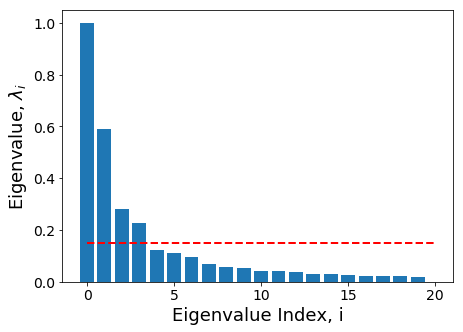

In [48]:
plt.figure(figsize=(7,5))
plt.bar(np.array(range(20)), wXdataflip)
ax = plt.subplot(1,1,1)
ax.set_xlabel('Eigenvalue Index, i',fontsize = 18)
ax.set_ylabel('Eigenvalue, $\lambda_i$',fontsize = 18)
ax.tick_params(labelsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.plot([-0,20], [0.15, 0.15], '--', lw=2,color = 'r')

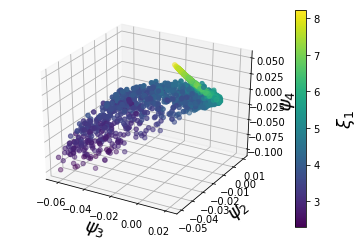

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
im = ax.scatter(-vXdata[:,2], -vXdata[:,1], vXdata[:,3], c=gt1final_n[:n+1], marker='o')
ax.set_xlabel(r'$\psi_3$',fontsize=18)
ax.set_ylabel(r'$\psi_2$',fontsize=18)
ax.set_zlabel(r'$\psi_4$',fontsize=18)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\xi_1$', rotation=90,fontsize=18)
plt.draw()
plt.show()

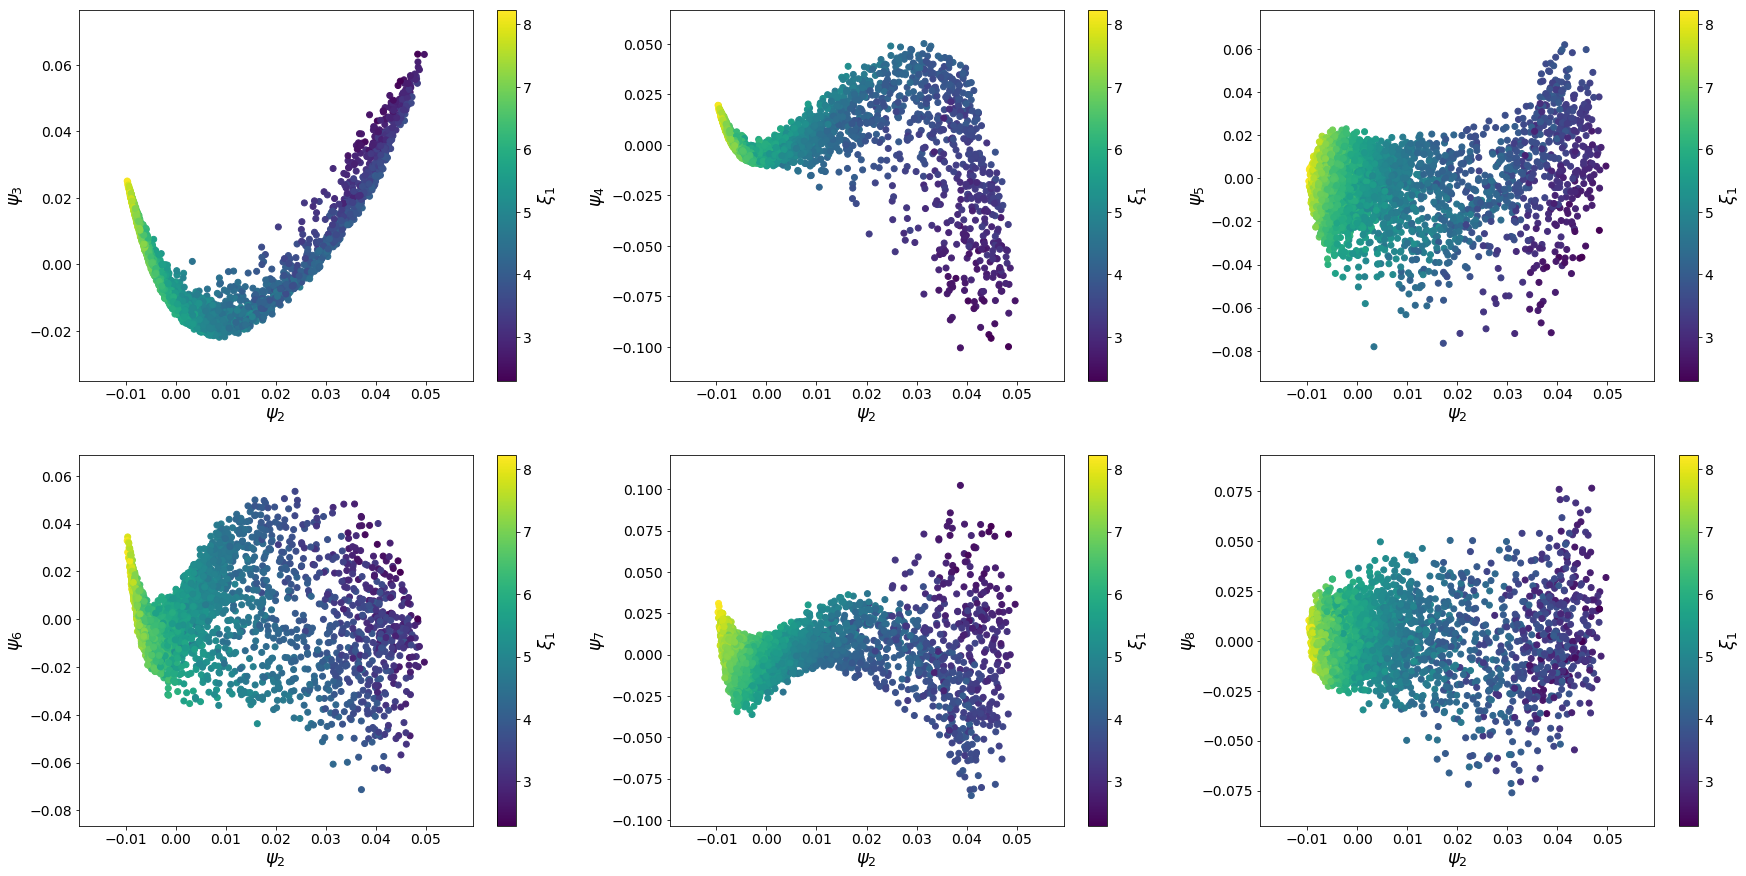

In [50]:
plt.figure(figsize=(30,15))
    # plotting trajectories 

ax1 = plt.subplot(2,3,1)
plt.scatter(vXdata[:,1], vXdata[:,2], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_3$',fontsize=18)
ax1.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax2 = plt.subplot(2,3,2)
plt.scatter(vXdata[:,1], vXdata[:,3], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_4$',fontsize=18)
ax2.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax3 = plt.subplot(2,3,3)
plt.scatter(vXdata[:,1], vXdata[:,4], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_5$',fontsize=18)
ax3.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)  

ax4 = plt.subplot(2,3,4)
plt.scatter(vXdata[:,1], vXdata[:,5], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_6$',fontsize=18)
ax4.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax5 = plt.subplot(2,3,5)
plt.scatter(vXdata[:,1], vXdata[:,6], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_7$',fontsize=18)
ax5.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax6 = plt.subplot(2,3,6)
plt.scatter(vXdata[:,1], vXdata[:,7], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_8$',fontsize=18)
ax6.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

# 6. Nystrom Extension

In [51]:
nystrom_x = np.zeros((N,20))

In [52]:
traj_N_n = traj_N_n.reshape(N-n-1,24,3)

In [53]:
nystrom_x[:n+1] = vXdata


In [54]:
for i in range(N-n-1):
    nystrom_x[n+i+1] = dmap.nystrom(distX.compute_single(traj_N_n.reshape(N-n-1,24,3)[i].reshape(-1),metric=dmaps.metrics.rmsd))
    

In [55]:
nystrom_x.shape

(5000, 20)

In [56]:
gt1final_n.shape


(4294,)

In [57]:
gt1final_N_n.shape


(706,)

In [58]:
gt11 = np.zeros(N)


In [59]:
gt11[:n+1] = gt1final_n


In [60]:
gt11[n+1:] = gt1final_N_n


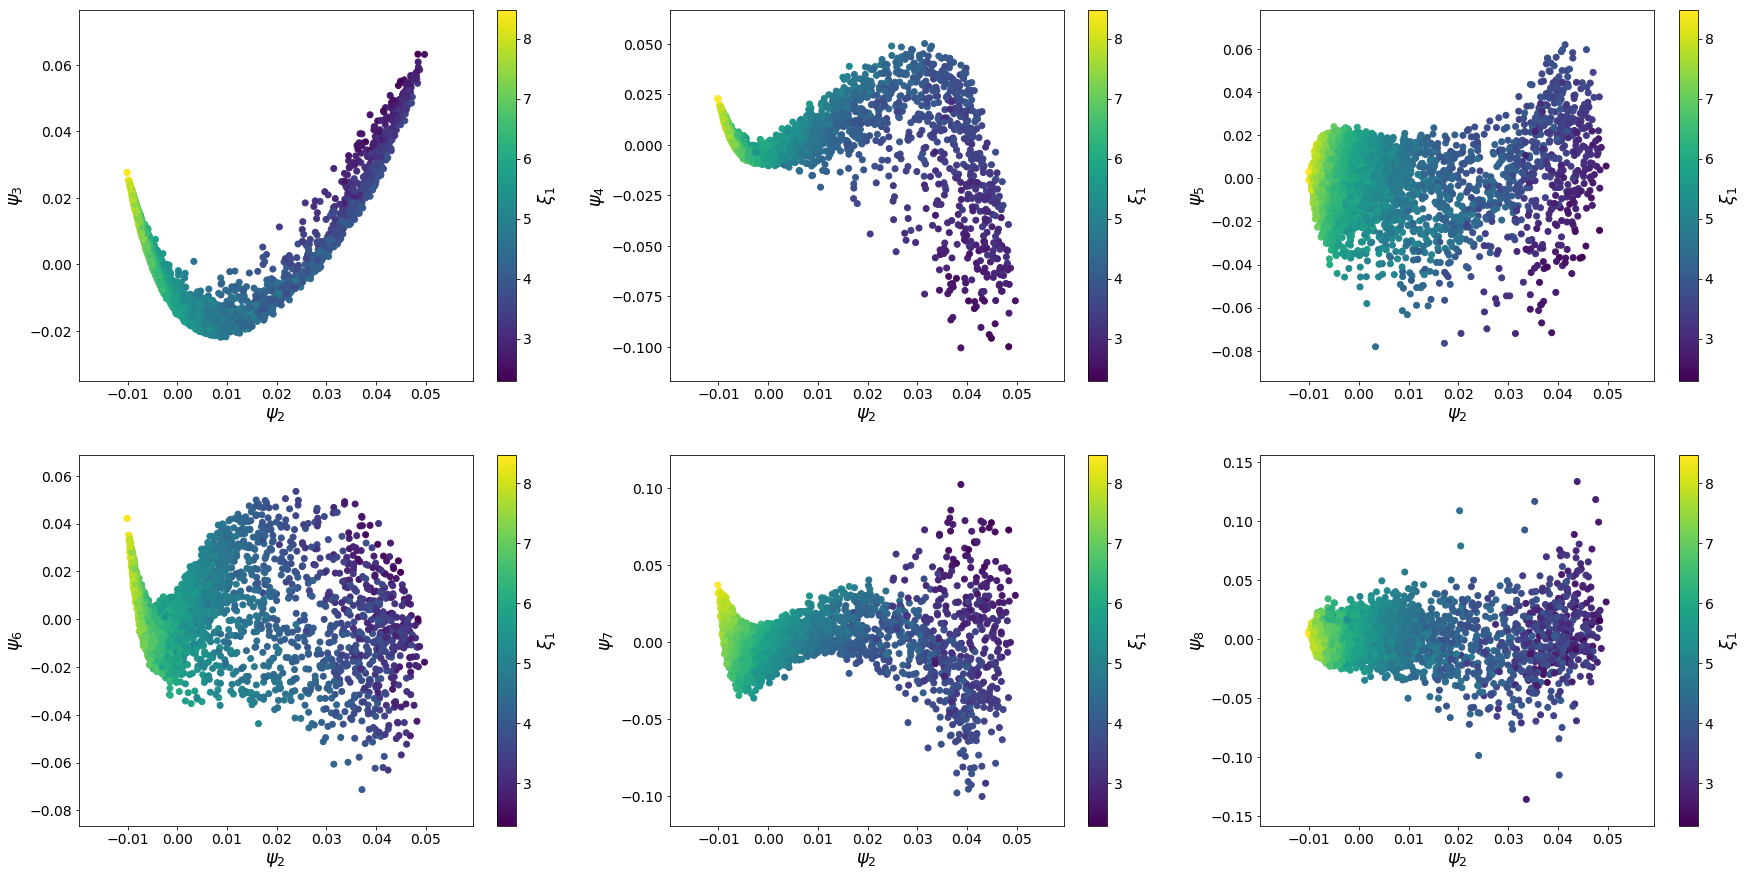

In [61]:
plt.figure(figsize=(30,15))
    # plotting trajectories 

ax1 = plt.subplot(2,3,1)
plt.scatter(nystrom_x[:,1], nystrom_x[:,2], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_3$',fontsize=18)
ax1.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax2 = plt.subplot(2,3,2)
plt.scatter(nystrom_x[:,1], nystrom_x[:,3], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_4$',fontsize=18)
ax2.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax3 = plt.subplot(2,3,3)
plt.scatter(nystrom_x[:,1], nystrom_x[:,4], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_5$',fontsize=18)
ax3.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)  

ax4 = plt.subplot(2,3,4)
plt.scatter(nystrom_x[:,1], nystrom_x[:,5], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_6$',fontsize=18)
ax4.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax5 = plt.subplot(2,3,5)
plt.scatter(nystrom_x[:,1], nystrom_x[:,6], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_7$',fontsize=18)
ax5.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax6 = plt.subplot(2,3,6)
plt.scatter(nystrom_x[:,1], nystrom_x[:,7], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_8$',fontsize=18)
ax6.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

# 7. Save data

In [62]:
np.savetxt('pivot_nystrom_x.txt',nystrom_x[:,1:])

In [63]:
B_n_1 = np.zeros((N-38,7))
gt_n_1 = np.zeros(N-38)
B_n_10 = np.zeros((N-38,7))
gt_n_10 = np.zeros(N-38)

In [64]:
nystrom_x.shape

(5000, 20)

In [65]:
B_n_10.shape

(4962, 7)

In [66]:
for i in range(B_n_1.shape[0]):
    gt_n_1[i] = gt11[i]
    B_n_1[i,0] = nystrom_x[i,1]
    B_n_1[i,1] = nystrom_x[i,2]
    B_n_1[i,2] = nystrom_x[i,3]
    B_n_1[i,3] = nystrom_x[i,4]
    B_n_1[i,4] = nystrom_x[i,5]
    B_n_1[i,5] = nystrom_x[i,6]
    B_n_1[i,6] = nystrom_x[i,7]
    
    gt_n_10[i] = gt11[i+20]
    B_n_10[i,0] = nystrom_x[i+20,1]
    B_n_10[i,1] = nystrom_x[i+20,2]
    B_n_10[i,2] = nystrom_x[i+20,3]
    B_n_10[i,3] = nystrom_x[i+20,4]
    B_n_10[i,4] = nystrom_x[i+20,5]
    B_n_10[i,5] = nystrom_x[i+20,6]
    B_n_10[i,6] = nystrom_x[i+20,7]    
    

In [67]:
np.savetxt('pivot_nystrom_x_10.txt',B_n_10)

In [68]:
np.savetxt('pivot_nystrom_x_1.txt',B_n_1)